In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pyro as pyro
import numpy as np
from pyro.infer import MCMC, NUTS, Predictive, HMC, config_enumerate
from pyro.infer.autoguide import AutoDelta, init_to_sample
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
from torch.distributions import constraints

In [6]:
torch.rand([3,6]).amax(dim = 0)

tensor([0.8497, 0.9070, 0.9316, 0.1821, 0.9697, 0.9125])

In [7]:
from pandas.core.common import flatten

def flatten_list(l):
    return list(flatten(l))


def log_sum_exp(args):
    c = torch.amax(args, dim = 0)  
    return c + torch.log(torch.sum(torch.exp(args - c), axis = 0))
                     
    
def beta_lk(beta_a, beta_b, weights, K, data):
    lk = torch.ones(K, len(data))
    for k in range(K):
        lk[k,:] = torch.log(weights[k]) + dist.Beta(beta_a[k], beta_b[k]).log_prob(data)
    return log_sum_exp(lk)

def final_lk(pareto, beta, weights):
    lk = torch.ones(2, len(beta))
    lk[0,:] = torch.log(weights[0]) + pareto
    lk[1,:] = torch.log(weights[1]) + beta
    return log_sum_exp(lk)

def retrieve_posterior_probs():
    pass
        
    
@config_enumerate
def model(data, K = 1 , tail = 1, purity =  0.96, clonal_beta_var = 1., alpha_prior_sd = 0.3,number_of_trials_clonal_mean = 500.,
          number_of_trials_clonal = 900., number_of_trials_k = 300., prior_lims_clonal = [0.1,100000.],
          prior_lims_k = [0.1,100000.] ):
    """
    Parameters
    ----------
    param1 :
    The first parameter.
    param2 : 
    The second parameter.
    
    """
    karyos = list(data.keys())
    major = [int(str(i).split(":")[0]) for i in karyos]
    minor = [int(str(i).split(":")[1]) for i in karyos]
    
    betas_subclone_mean2 = 0
    betas_subclone_n_samples2 = 0
    betas_subclone_mean = 0
    betas_subclone_n_samples = 0
    
    lk = np.zeros(len(karyos))
    
    theoretical_num_clones = [1 if (mn == 0 or mn == mj) else 2 for mj,mn in zip(major,minor)]
    theoretical_clonal_means = [(purity - 0.0001) if (mn == 0 or mn == mj) else torch.tensor([(mj/(mj + mn)) * purity, (mn/(mn + mj)) * purity]) for mj,mn in zip(major, minor)]
    theoretical_clonal_means = [0.5 * purity if (mn == mj) else j for mj,mn,j in zip(major, minor, theoretical_clonal_means)]

    counts_clones = dict()
    for i in theoretical_num_clones:
        counts_clones[i] = counts_clones.get(i, 0) + 1
        
    index_2 = [i for i, j in enumerate(theoretical_num_clones) if j == 2]
    index_1 = [i for i, j in enumerate(theoretical_num_clones) if j == 1]
    

    alpha_prior =  pyro.sample('u', dist.Uniform(0.5, 5))

    for kr in pyro.plate("kr",len(karyos)):
        
        
        alpha =  pyro.sample('alpha_{}'.format(kr), dist.LogNormal(torch.log(alpha_prior), alpha_prior_sd))

        if theoretical_num_clones[kr] == 2:
            weights_2 = pyro.sample('weights_{}'.format(kr), dist.Dirichlet(torch.ones(K + 2)))

            with pyro.plate("clones_{}".format(kr), 2 + K):
                
                
                k_means = [(torch.min(theoretical_clonal_means[kr] - 0.05) / 2).tolist()] * K
                bm_12 = torch.tensor(flatten_list([theoretical_clonal_means[kr].tolist(),k_means])) * number_of_trials_clonal_mean
                bm_22 = number_of_trials_clonal_mean - bm_12
                betas_subclone_mean2 = pyro.sample('beta_clone_mean_{}'.format(kr), dist.Beta(bm_12, bm_22))
                bns_12 = torch.tensor((2 * [prior_lims_clonal[0]]) + (K * [prior_lims_k[0]]))
                bns_22 = torch.tensor((2 * [prior_lims_clonal[1]]) + (K * [prior_lims_k[1]]))
                betas_subclone_n_samples2 = pyro.sample('beta_clone_n_samples_{}'.format(kr), dist.Uniform(bns_12,bns_22))
                
        else:
            weights_1 = pyro.sample('weights_{}'.format(kr), dist.Dirichlet(torch.ones(K + 1)))

            with pyro.plate("clones_{}".format(kr), 1 + K):

                k_means = [(theoretical_clonal_means[kr] - 0.05) / 2] * K
                bm_11 =  torch.tensor(flatten_list([theoretical_clonal_means[kr],k_means])) * number_of_trials_clonal_mean
                bm_21 = number_of_trials_clonal_mean - bm_11
                betas_subclone_mean = pyro.sample('beta_clone_mean_{}'.format(kr),dist.Beta(bm_11, bm_21))
                bns_11 = torch.tensor((1 * [prior_lims_clonal[0]]) + (K * [prior_lims_k[0]]))
                bns_21 = torch.tensor((1 * [prior_lims_clonal[1]]) + (K * [prior_lims_k[1]]))
                betas_subclone_n_samples = pyro.sample('beta_clone_n_samples_{}'.format(kr), dist.Uniform(bns_11, bns_21))
                
                
        tail_probs = pyro.sample('weights_tail_{}'.format(kr), dist.Dirichlet(torch.ones(2)))
        with pyro.plate('data_{}'.format(kr), len(data[karyos[kr]])):
        
            if(tail == 1):
                if theoretical_num_clones[kr] == 2:
                    beta = beta_lk(betas_subclone_mean2 * betas_subclone_n_samples2,
                                                                (1 - betas_subclone_mean2) * betas_subclone_n_samples2,
                                                                weights_2,K + theoretical_num_clones[kr], 
                                                                data[karyos[kr]])
                    pareto = dist.Pareto(torch.min(data[karyos[kr]]) - 1e-5, alpha).log_prob(data[karyos[kr]])
                    pyro.factor("lik_{}".format(kr),torch.sum(final_lk(pareto, beta, tail_probs)))
                  

                else:                    
                    beta = beta_lk(betas_subclone_mean * betas_subclone_n_samples,
                                                                (1 - betas_subclone_mean) * betas_subclone_n_samples,
                                                                weights_1,K + theoretical_num_clones[kr], 
                                                                data[karyos[kr]])
                    pareto = dist.Pareto(torch.min(data[karyos[kr]]) - 1e-5, alpha).log_prob(data[karyos[kr]])
                    pyro.factor("lik_{}".format(kr),torch.sum(final_lk(pareto, beta, tail_probs)))
                                
            else:

                if theoretical_num_clones[kr] == 2:
                    pyro.factor("lik_{}".format(kr), torch.sum(beta_lk(betas_subclone_mean2 * betas_subclone_n_samples2,
                                                                (1 - betas_subclone_mean2) * betas_subclone_n_samples2,
                                                                weights_2,K + theoretical_num_clones[kr], 
                                                                data[karyos[kr]])))
                else:
                    pyro.factor("lik_{}".format(kr), torch.sum(beta_lk(betas_subclone_mean * betas_subclone_n_samples, 
                                                                (1 - betas_subclone_mean) * betas_subclone_n_samples, 
                                                                weights_1,
                                                                K + theoretical_num_clones[kr], 
                                                                data[karyos[kr]])))
                    
@config_enumerate
def guide(data, K = 1 , tail = 1, purity =  0.96, clonal_beta_var = 1., alpha_prior_sd = 0.3,number_of_trials_clonal_mean = 100.,
          number_of_trials_clonal = 900., number_of_trials_k = 300., prior_lims_clonal = [1.,10000.],
          prior_lims_k = [1.,10000.]):
    """
    Parameters
    ----------
    param1 :
    The first parameter.
    param2 : 
    The second parameter.
    
    """
    karyos = list(data.keys())
    major = [int(str(i).split(":")[0]) for i in karyos]
    minor = [int(str(i).split(":")[1]) for i in karyos]
    
    
    lk = np.zeros(len(karyos))
    
    theoretical_num_clones = [1 if (mn == 0 or mn == mj) else 2 for mj,mn in zip(major,minor)]
    theoretical_clonal_means = [(purity - 0.0001) if (mn == 0 or mn == mj) else torch.tensor([(mj/(mj + mn)) * purity, (mn/(mn + mj)) * purity]) for mj,mn in zip(major, minor)]
    theoretical_clonal_means = [0.5 * purity if (mn == mj) else j for mj,mn,j in zip(major, minor, theoretical_clonal_means)]
    
    counts_clones = dict()
    for i in theoretical_num_clones:
        counts_clones[i] = counts_clones.get(i, 0) + 1
        
    index_2 = [i for i, j in enumerate(theoretical_num_clones) if j == 2]
    index_1 = [i for i, j in enumerate(theoretical_num_clones) if j == 1]
    
    ap = pyro.param("ap", torch.tensor(1.5),  constraint = constraints.interval(0.5,5))
    
    alpha_prior =  pyro.sample('u', dist.Delta(ap))
    

    

    
        
    idx1 = 0
    idx2 = 0
    
    weights_tail = pyro.param("param_tail_weights", 1/torch.ones([len(karyos),2]), constraint = constraints.simplex)
    weights_param_2 = pyro.param("param_weights_2", (1/(K + 2)) * torch.ones([ len(index_2), K + 2]), constraint = constraints.simplex)
    weights_param_1 = pyro.param("param_weights_1",(1/(K + 1)) * torch.ones([len(index_1), K + 1]), constraint = constraints.simplex)
    

    for kr in pyro.plate("kr",len(karyos)):
                
        pyro.sample('alpha_{}'.format(kr), dist.LogNormal(torch.log(alpha_prior), alpha_prior_sd))

        
        if theoretical_num_clones[kr] == 2:
            
            pyro.sample('weights_{}'.format(kr), dist.Delta(weights_param_2[idx2]).to_event(1))

            # Mean parameter when the number of clonal picks is 2 
            a_2_theo = torch.cat([theoretical_clonal_means[i] for i in index_2]).reshape([2, counts_clones[2]])
            max_lim_2 = torch.tensor([torch.min(theoretical_clonal_means[i]) for i in index_2])
            a_2_k = dist.Uniform(0.1, max_lim_2 - (0.3 * max_lim_2)).sample([K])

            # Number of trials parameter when the number of clonal picks is 2 
            b_2_theo = torch.ones([2,len(index_2)]) * number_of_trials_clonal_mean
            b_2_k = torch.ones([K,len(index_2)]) * number_of_trials_k
            
            
            
            a21 =  pyro.param('a_2', 
                                 torch.cat((a_2_theo, a_2_k)).reshape([2 + K,len(index_2)]), 
                                 constraint = constraints.unit_interval)
            a22 =  pyro.param('b_2', 
                                 torch.cat((b_2_theo, b_2_k)).reshape([2 + K,len(index_2)]),
                                 constraint = constraints.positive)
    
            
            with pyro.plate("clones_{}".format(kr), 2 + K):
                pyro.sample('beta_clone_mean_{}'.format(kr),dist.Delta(a21[:,idx2]))
                pyro.sample('beta_clone_n_samples_{}'.format(kr),dist.Delta(a22[:,idx2]))
            idx2 += 1 
                
        else:
            pyro.sample('weights_{}'.format(kr), dist.Delta(weights_param_1[idx1]).to_event(1))

            
            # Mean parameter when the number of clonal picks is 1
            a_1_theo = torch.tensor([theoretical_clonal_means[i] for i in index_1]).reshape([1, counts_clones[1]])
            max_lim_1 = torch.tensor([np.min(theoretical_clonal_means[i]) for i in index_1])
            a_1_k = dist.Uniform(0.1, max_lim_1 - (0.3 * max_lim_1)).sample([K])

            # Number of trials parameter when the number of clonal picks is 1 
            b_1_theo = torch.ones([1,len(index_1)]) * number_of_trials_clonal_mean
            b_1_k = torch.ones([K,len(index_1)]) * number_of_trials_k 
            
            
            a11 =  pyro.param('a_1', 
                         torch.cat((a_1_theo, a_1_k)).reshape([1 + K,len(index_1)]), 
                         constraint = constraints.unit_interval)
            a12 =  pyro.param('b_1', 
                         torch.cat((b_1_theo, b_1_k)).reshape([1 + K,len(index_1)]),
                         constraint = constraints.positive)

            with pyro.plate("clones_{}".format(kr), 1 + K):
                pyro.sample('beta_clone_mean_{}'.format(kr),dist.Delta(a11[:,idx1]))
                pyro.sample('beta_clone_n_samples_{}'.format(kr),dist.Delta(a12[:,idx1]))
            idx1 += 1 
                
            
        #K = K + tail
        pyro.sample('weights_tail_{}'.format(kr), dist.Delta(weights_tail[kr]).to_event(1))
        

        


In [8]:
import pickle
flh = open("example.pkl", "rb")
inp = pickle.load(flh)

In [9]:
inp = {k : (torch.tensor(v) - 0.001) for k,v in zip(inp.keys(),inp.values())}


In [10]:
def run(model, data,N_warm = 2000, N_samples = 3000, seed = 3, tail = 1, purity = 1):
    pyro.set_rng_seed(seed)
    kernel = HMC(model)
    mcmc = MCMC(kernel,warmup_steps = N_warm, num_samples = N_samples)
    mcmc.run(data , tail = tail, purity = purity)
    mcmc.print_summary()
    samples = mcmc.get_samples()
    return (mcmc, samples)

In [11]:
svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=pyro.optim.Adam({"lr": 0.05}),
                     loss=pyro.infer.TraceGraph_ELBO())

In [12]:
pyro.clear_param_store()
losses = []
for i in range(500):
    loss = svi.step(inp, tail = 1, K = 1)
    losses.append(loss)
    #plot_results(inp, tail = True)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

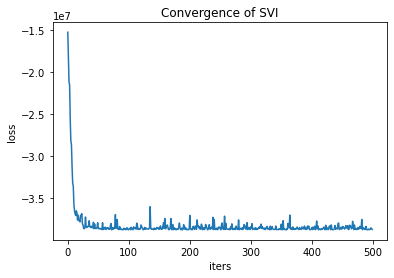

In [13]:
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.title('Convergence of SVI');

In [14]:
from scipy.stats import beta,pareto
import matplotlib.patches as mpatches

plt.rcParams["figure.figsize"] = (10,8)

def plot_results(data, bins = 50, tail = True):
    
    fig, axs = plt.subplots(3)
    idx1 = 0
    idx2 = 0
    for i,kr in enumerate(data):
        
        axs[i].hist(data[kr].detach().numpy(), bins=bins, density=True, alpha=0.48)
        xmin, xmax = plt.xlim()
        karyos = list(data.keys())
        major = [int(str(i).split(":")[0]) for i in karyos]
        minor = [int(str(i).split(":")[1]) for i in karyos]
        theoretical_num_clones = [1 if (mn == 0 or mn == mj) else 2 for mj,mn in zip(major,minor)]
        assignment_probs = pyro.param('param_weights_{}'.format(theoretical_num_clones[i])).detach().numpy()
        if tail:
            tail_probs = pyro.param('param_tail_weights').detach().numpy()

        
        for j in range(assignment_probs.shape[1]):
            if theoretical_num_clones[i] == 1:
                b1 = pyro.param('b_1') 
                a1 = pyro.param('a_1') 
                beta_mean = a1[j,idx1].detach().numpy()
                beta_samples = b1[j,idx1].detach().numpy()
                iw = idx1
                cl = "tab:green" if j < 1 else "tab:red"
                
            else:
                b2 = pyro.param('b_2') 
                a2 = pyro.param('a_2') 
                beta_mean = a2[j,idx2].detach().numpy()
                beta_samples = b2[j,idx2].detach().numpy()
                iw = idx2
                cl = "tab:green" if j < 2 else "tab:red"
             
            x = np.linspace(0.05, 1, 200)
            if tail:
                p = beta.pdf(x, beta_mean * beta_samples, (1 - beta_mean) * beta_samples) * assignment_probs[iw,j] * tail_probs[i,1]
            else:
                p = beta.pdf(x, beta_mean * beta_samples, (1 - beta_mean) * beta_samples) * assignment_probs[iw,j] 

            axs[i].plot(x, p, linewidth=3, color = cl)
        if tail:
            alpha = pyro.param('ap'.format(i)).detach().numpy()
            x = np.linspace(0.05, 1, 200)
            p = pareto.pdf(x,alpha,scale = torch.min(data[kr])) * tail_probs[i,0]
            axs[i].plot(x, p, linewidth=3, color = "tab:pink")
        if theoretical_num_clones[i] == 1:
            idx1+=1
        else:
            idx2+=1
    pink_patch = mpatches.Patch(color='tab:pink', label='Tail')
    red_patch = mpatches.Patch(color='tab:red', label='Subclonal')
    green_patch = mpatches.Patch(color='tab:green', label='Clonal')

    plt.legend(handles = [pink_patch,red_patch, green_patch ])

        
    plt.savefig("results1.png", dpi = 300)

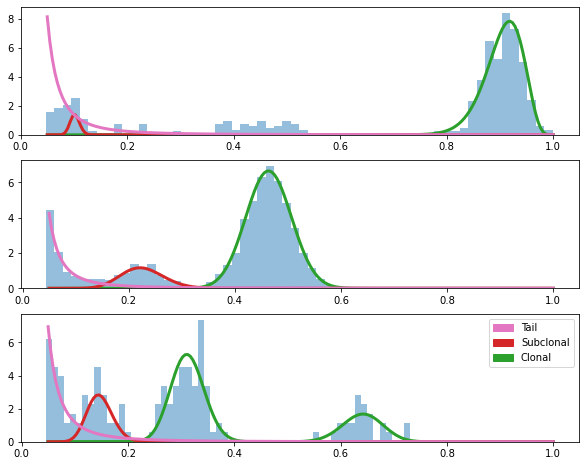

In [15]:
plot_results(inp, tail = True, bins = 60)

In [16]:
#run(model, inp, N_warm = 0)

Warmup:   0%|          | 1/3000 [10:50, 650.67s/it, step size=2.44e-04, acc. prob=0.000]

KeyboardInterrupt: 

In [17]:
pyro.param('param_weights_1') 

tensor([[0.9565, 0.0435],
        [0.8599, 0.1401]], grad_fn=<DivBackward0>)

In [18]:
pyro.param('ap') 

tensor(1.5379, grad_fn=<AddBackward0>)

(array([8.780e+02, 4.870e+02, 3.110e+02, 8.150e+02, 3.102e+03, 3.880e+02,
        5.000e+00, 3.000e+00, 2.000e+00, 8.000e+00]),
 array([0.04404505, 0.13954054, 0.23503605, 0.33053154, 0.42602703,
        0.5215225 , 0.61701804, 0.7125135 , 0.808009  , 0.9035045 ,
        0.999     ], dtype=float32),
 <BarContainer object of 10 artists>)

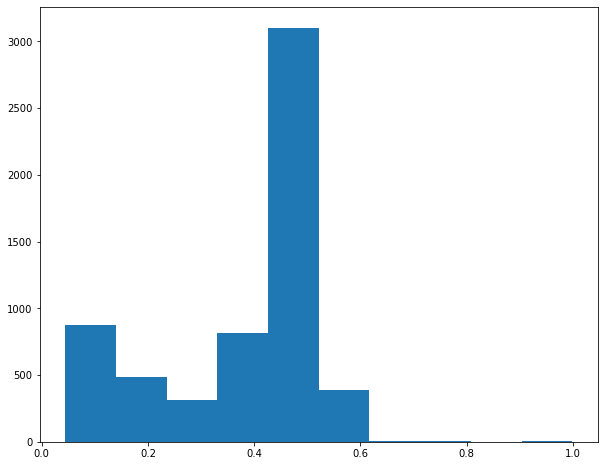

In [19]:
plt.hist(inp["1:1"].detach().numpy())

In [28]:
param_names = pyro.get_param_store()
res = {nms: pyro.param(nms) for nms in param_names}
res

{'ap': tensor(1.5379, grad_fn=<AddBackward0>),
 'param_tail_weights': tensor([[0.2858, 0.7142],
         [0.1677, 0.8323],
         [0.2578, 0.7422]], grad_fn=<DivBackward0>),
 'param_weights_2': tensor([[0.2139, 0.5600, 0.2261]], grad_fn=<DivBackward0>),
 'param_weights_1': tensor([[0.9565, 0.0435],
         [0.8599, 0.1401]], grad_fn=<DivBackward0>),
 'a_1': tensor([[0.9051, 0.4640],
         [0.1018, 0.2265]], dtype=torch.float64, grad_fn=<ClampBackward>),
 'b_1': tensor([[  64.2426,  135.5838],
         [1163.1294,  108.5413]], grad_fn=<AddBackward0>),
 'a_2': tensor([[0.6407],
         [0.3124],
         [0.1475]], grad_fn=<ClampBackward>),
 'b_2': tensor([[161.1578],
         [217.7212],
         [222.3971]], grad_fn=<AddBackward0>)}

In [21]:

def compute_likelihood_from_params_tail(data, params, i, theo_clones, counts_clone):
    j = counts_clone[i]
    if theo_clones[i] == 2:
        beta = beta_lk(params['a_2'][:,j] * params['b_2'][:,j],
                       (1 - params['a_2'][:,j]) * params['b_2'][:, j],
                       params['param_weights_{}'.format(theo_clones[i])][j, :],
                       len(params['a_2'][:, j]),
                       data)
        pareto = dist.Pareto(torch.min(data) - 1e-5, params['ap']).log_prob(data)
        lk = final_lk(pareto, beta, params['param_tail_weights'][i, :])
    else:
        beta = beta_lk(params['a_1'][:, j] * params['b_1'][:, j],
                       (1 - params['a_1'][:, i]) * params['b_1'][:, j],
                       params['param_weights_{}'.format(theo_clones[i])][j,:],
                       len(params['a_1'][:, j]),
                       data)
        pareto = dist.Pareto(torch.min(data) - 1e-5, params['ap']).log_prob(data)
        lk = final_lk(pareto, beta, params['param_tail_weights'][i, :])
    return lk

In [26]:
compute_likelihood_from_params_tail(inp["2:1"], res, 2,get_theo_clones(inp), get_clones_counts(get_theo_clones(inp)))

tensor([ 1.1767,  1.8259,  1.2462,  2.0404,  1.3214,  0.8809,  1.9891,  0.2849,
         0.4963,  0.4918,  1.4422,  0.6641,  1.1970,  1.4656,  1.7592,  1.6170,
         0.9522,  1.9783,  2.1563,  1.6190,  1.1294,  1.4727,  0.7257, -0.3881,
         2.1563,  1.1710,  1.6399,  0.4212,  0.6235,  0.9152,  0.8287,  1.3352,
         1.1661,  1.0436,  1.6236,  1.5572,  1.6640,  0.8891,  1.6755, -0.6652,
         1.3802,  1.2226,  0.9821,  0.7567,  1.5586,  1.4354,  1.6049,  1.3782,
         1.6136,  1.5956,  1.0892,  1.6465,  0.3081,  1.9674, -0.2728,  1.6703,
         1.4159,  0.8239,  0.6221,  1.6763,  0.0711,  1.2467,  0.4054,  1.6731,
         1.2064,  0.8311,  1.5648,  1.6503,  1.1095,  1.0935,  0.4212,  0.3948,
         0.0711,  0.5058,  0.5206,  0.9357,  0.4412,  0.4655,  0.4913,  1.6449,
         1.1958,  1.1949,  1.6040,  0.2063,  1.4596, -0.5022, -0.1861, -0.1283,
         0.5166,  0.0182,  1.1951,  0.4693,  0.4591,  0.9972,  0.5013,  1.2687,
         0.1796,  1.0542,  0.1456,  1.27

In [ ]:
res['param_tail_weights'][0,:]

In [ ]:
params = res


In [23]:
def get_clones_counts(theoretical_num_clones):
    uniques = list(set(theoretical_num_clones))
    uniques = {k : 0 for k in uniques}
    res = [None] * len(theoretical_num_clones)
    for i in range(len(theoretical_num_clones)):
        res[i] = uniques[theoretical_num_clones[i]]
        uniques[theoretical_num_clones[i]] += 1
    return(res)

In [24]:
def get_theo_clones(data):
    karyos = list(data.keys())
    major = [int(str(i).split(":")[0]) for i in karyos]
    minor = [int(str(i).split(":")[1]) for i in karyos]
    theoretical_num_clones = [1 if (mn == 0 or mn == mj) else 2 for mj, mn in zip(major, minor)]
    return theoretical_num_clones


In [67]:
theo_clones = get_clones_counts(get_theo_clones(inp))

In [75]:
beta = beta_lk(params['a_2'][:,0] * params['b_2'][:,0],
                       (1 - params['a_2'][:,0]) * params['b_2'][:, 0],
                       params['param_weights_{}'.format(get_theo_clones(inp)[2])][0, :],
                       len(params['a_2'][:,0]),
                       inp["2:1"])

In [76]:
log_sum_exp(beta).sum()

tensor(-117.1100, grad_fn=<SumBackward0>)

In [ ]:
def beta_lk(beta_a, beta_b, weights, K, data):
    lk = torch.ones(K, len(data))
    if K == 1:
        return torch.log(weights) + dist.Beta(beta_a, beta_b).log_prob(data)
    for k in range(K):
        lk[k, :] = torch.log(weights[k]) + dist.Beta(beta_a[k], beta_b[k]).log_prob(data)
    return lk